In [3]:
import argparse
import os 
import copy 
import pickle
import numpy as np
import pandas as pd
import torch
import utils
from utils import AverageMeterSet
import prepare_data
import models
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=None, shuffle=False)
from datetime import date
today = date.today()
date = today.strftime("%m%d")
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams["figure.dpi"] = 300
plt.style.use('bmh')
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
legend_properties = {'weight':'bold', 'size': 14}


if __name__ == "__main__":

    parser = argparse.ArgumentParser(description="Parser for time series VAE models")
    # data/loss parameters
    parser.add_argument("--use_sepsis3", action = 'store_false', default= True, help="Whethe only use sepsis3 subset")
    parser.add_argument("--bucket_size", type=int, default=300, help="bucket size to group different length of time-series data")
    parser.add_argument("--beta", type=float, default=0.0001, help="coefficent for the elbo loss")
    parser.add_argument("--gamma", type=float, default=0.5, help="coefficent for the total_corr loss")
    parser.add_argument("--alpha", type=float, default=0.5, help="coefficent for the clf loss")
    parser.add_argument("--zdim", type=int, default=20, help="dimension of the latent space")
    # model parameters
    parser.add_argument("--kernel_size", type=int, default=3, help="kernel size")
    parser.add_argument("--drop_out", type=float, default=0.2, help="drop out rate")
    parser.add_argument("--enc_channels", default=[256, 64, 16, 2],  help="number of channels in the encoder")
    parser.add_argument("--dec_channels", default = [16, 64, 256, 200], help="number of channels in the decoder")
    parser.add_argument("--num_inputs", type=int, default=200, help="number of features in the inputs")
    # discriminator parameters
    parser.add_argument("--disc_channels",  type=int, default=200, help="number of channels in the discriminator")
    # regressor parameters
    parser.add_argument("--regr_channels",  type=int, default=200, help="number of channels in the regressor")
    # training parameters
    parser.add_argument("--epochs", type=int, default=300, help="Number of training epochs")
    parser.add_argument("--data_batching", type=str, default='close', choices=['same', 'close', 'random'], help='How to batch data')
    parser.add_argument("--bs", type=int, default=16, help="batch size")
    parser.add_argument("--lr", type=float, default=1e-4, help="Learning rate")
    parser.add_argument("--patience", type=int, default=20, help="Patience epochs for early stopping.")
    parser.add_argument("--checkpoint", type=str, default='test', help=" name of checkpoint model")

    args = parser.parse_known_args()[0]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    arg_dict = vars(args)
    workname = date + "_" +  args.checkpoint
    utils.creat_checkpoint_folder('/content/drive/My Drive/ColabNotebooks/MIMIC/TCN/VAE/checkpoints/' + workname, 'params.json', arg_dict)

    # load data
    meep_mimic = np.load('/content/drive/MyDrive/ColabNotebooks/MIMIC/Extract/MEEP/Extracted_sep_2022/0910/MIMIC_compile_0911_2022.npy', \
                    allow_pickle=True).item()
    train_vital = meep_mimic ['train_head']
    dev_vital = meep_mimic ['dev_head']
    test_vital = meep_mimic ['test_head']
    mimic_static = np.load('/content/drive/MyDrive/ColabNotebooks/MIMIC/Extract/MEEP/Extracted_sep_2022/0910/MIMIC_static_0922_2022.npy', \
                            allow_pickle=True).item()
    mimic_target = np.load('/content/drive/MyDrive/ColabNotebooks/MIMIC/Extract/MEEP/Extracted_sep_2022/0910/MIMIC_target_0922_2022.npy', \
                            allow_pickle=True).item()
        
    train_head, train_static, train_sofa, train_id =  utils.crop_data_target('mimic', train_vital, mimic_target, mimic_static, 'train')
    dev_head, dev_static, dev_sofa, dev_id =  utils.crop_data_target('mimic', dev_vital , mimic_target, mimic_static, 'dev')
    test_head, test_static, test_sofa, test_id =  utils.crop_data_target('mimic', test_vital, mimic_target, mimic_static, 'test')

    if args.use_sepsis3 == True:
        train_head, train_static, train_sofa, train_id = utils.filter_sepsis('mimic', train_head, train_static, train_sofa, train_id)
        dev_head, dev_static, dev_sofa, dev_id = utils.filter_sepsis('mimic', dev_head, dev_static, dev_sofa, dev_id)
        test_head, test_static, test_sofa, test_id = utils.filter_sepsis('mimic', test_head, test_static, test_sofa, test_id)

    # build model
    model = models.Ffvae(args)

    # 10-fold cross validation
    trainval_head = train_head + dev_head
    trainval_static = train_static + dev_static
    trainval_stail = train_sofa + dev_sofa
    trainval_ids = train_id + dev_id

    # prepare data
    torch.autograd.set_detect_anomaly(True)
    for c_fold, (train_index, test_index) in enumerate(kf.split(trainval_head)):
        
        # if c_fold >= 1:
        #     model.load_state_dict(torch.load('/content/start_weights.pt'))
        print('Starting Fold %d' % c_fold)
        print("TRAIN:", len(train_index), "TEST:", len(test_index))
        train_head, val_head = utils.slice_data(trainval_head, train_index), utils.slice_data(trainval_head, test_index)
        train_static, val_static = utils.slice_data(trainval_static, train_index), utils.slice_data(trainval_static, test_index)
        train_stail, val_stail = utils.slice_data(trainval_stail, train_index), utils.slice_data(trainval_stail, test_index)
        train_id, val_id = utils.slice_data(trainval_ids, train_index), utils.slice_data(trainval_ids, test_index)

        train_dataloader, dev_dataloader, test_dataloader = prepare_data.get_data_loader(args, train_head, val_head,
                                                                                            test_head, 
                                                                                            train_stail, val_stail,
                                                                                            test_sofa,
                                                                                            train_static=train_static,
                                                                                            dev_static=val_static,
                                                                                            test_static=test_static,
                                                                                            train_id=train_id,
                                                                                            dev_id=val_id,
                                                                                            test_id=test_id)
        # df to record loss

Starting Fold 0
TRAIN: 11786 TEST: 2947
Starting Fold 1
TRAIN: 11786 TEST: 2947
Starting Fold 2
TRAIN: 11786 TEST: 2947
Starting Fold 3
TRAIN: 11787 TEST: 2946
Starting Fold 4
TRAIN: 11787 TEST: 2946


In [ ]:
os.makedirs(target_path + '/auc_plots')
os.makedirs(target_path + '/auc_plots_cv')
os.makedirs(target_path + '/cm_maps')
os.makedirs(target_path + '/cm_maps_cv')

In [ ]:
# load cross validation data 
 meep_eicu = np.load('/content/drive/MyDrive/ColabNotebooks/MIMIC/Extract/MEEP/Extracted_sep_2022/0910/eICU_compile_0911_2022_2.npy', \
                    allow_pickle=True).item()
train_vital_e = meep_eicu['train_head']
dev_vital_e = meep_eicu ['dev_head']
test_vital_e = meep_eicu ['test_head']
eicu_static = np.load('/content/drive/MyDrive/ColabNotebooks/MIMIC/Extract/MEEP/Extracted_sep_2022/0910/eICU_static_0922_2022.npy', \
                        allow_pickle=True).item()
eicu_target = np.load('/content/drive/MyDrive/ColabNotebooks/MIMIC/Extract/MEEP/Extracted_sep_2022/0910/eICU_target_0922_2022.npy', \
                        allow_pickle=True).item()

In [8]:
# load saved pt files 
import glob 
base_dir = '/content/drive/My Drive/ColabNotebooks/MIMIC/TCN/VAE/checkpoints/'
workname = '0421_lr1e-4beta1e-3-1/'
all_path = glob.glob(base_dir+workname + '*.pt')

In [14]:
args.zdim=60
model = models.Ffvae(args)

In [15]:
import sklearn.metrics as metrics
import seaborn as sns 
import torch.nn as nn 

for p in all_path: 
    model.load_state_dict(torch.load(p))
    #  test on test loader 
    model.eval()
    logits = []
    stt = []
    with torch.no_grad():
        for vitals, static, target, train_ids, key_mask in test_dataloader:
            vitals = vitals.to(device)
            static = static[:, 0].to(device)
            target = target.to(device)
            key_mask = key_mask.to(device)

            # _mu shape [bs, zdim]
            _mu, _logvar = model.encoder(vitals)
            # b_logits [bs, 1]
            b_logits = _mu[:, model.sens_idx]
            logits.extend(b_logits)
            stt.extend(static)
    logits = torch.stack(logits)
    stt = torch.stack(stt) 
    metrics.RocCurveDisplay.from_predictions(stt.cpu(),  nn.Sigmoid()(logits).cpu())  
    plt.savefig('./checkpoints/' + workname + '/auc_plots_cv/' + '%s_prc.eps'%wname, format='eps', bbox_inches = 'tight', pad_inches = 0.1, dpi=1200)
            
       

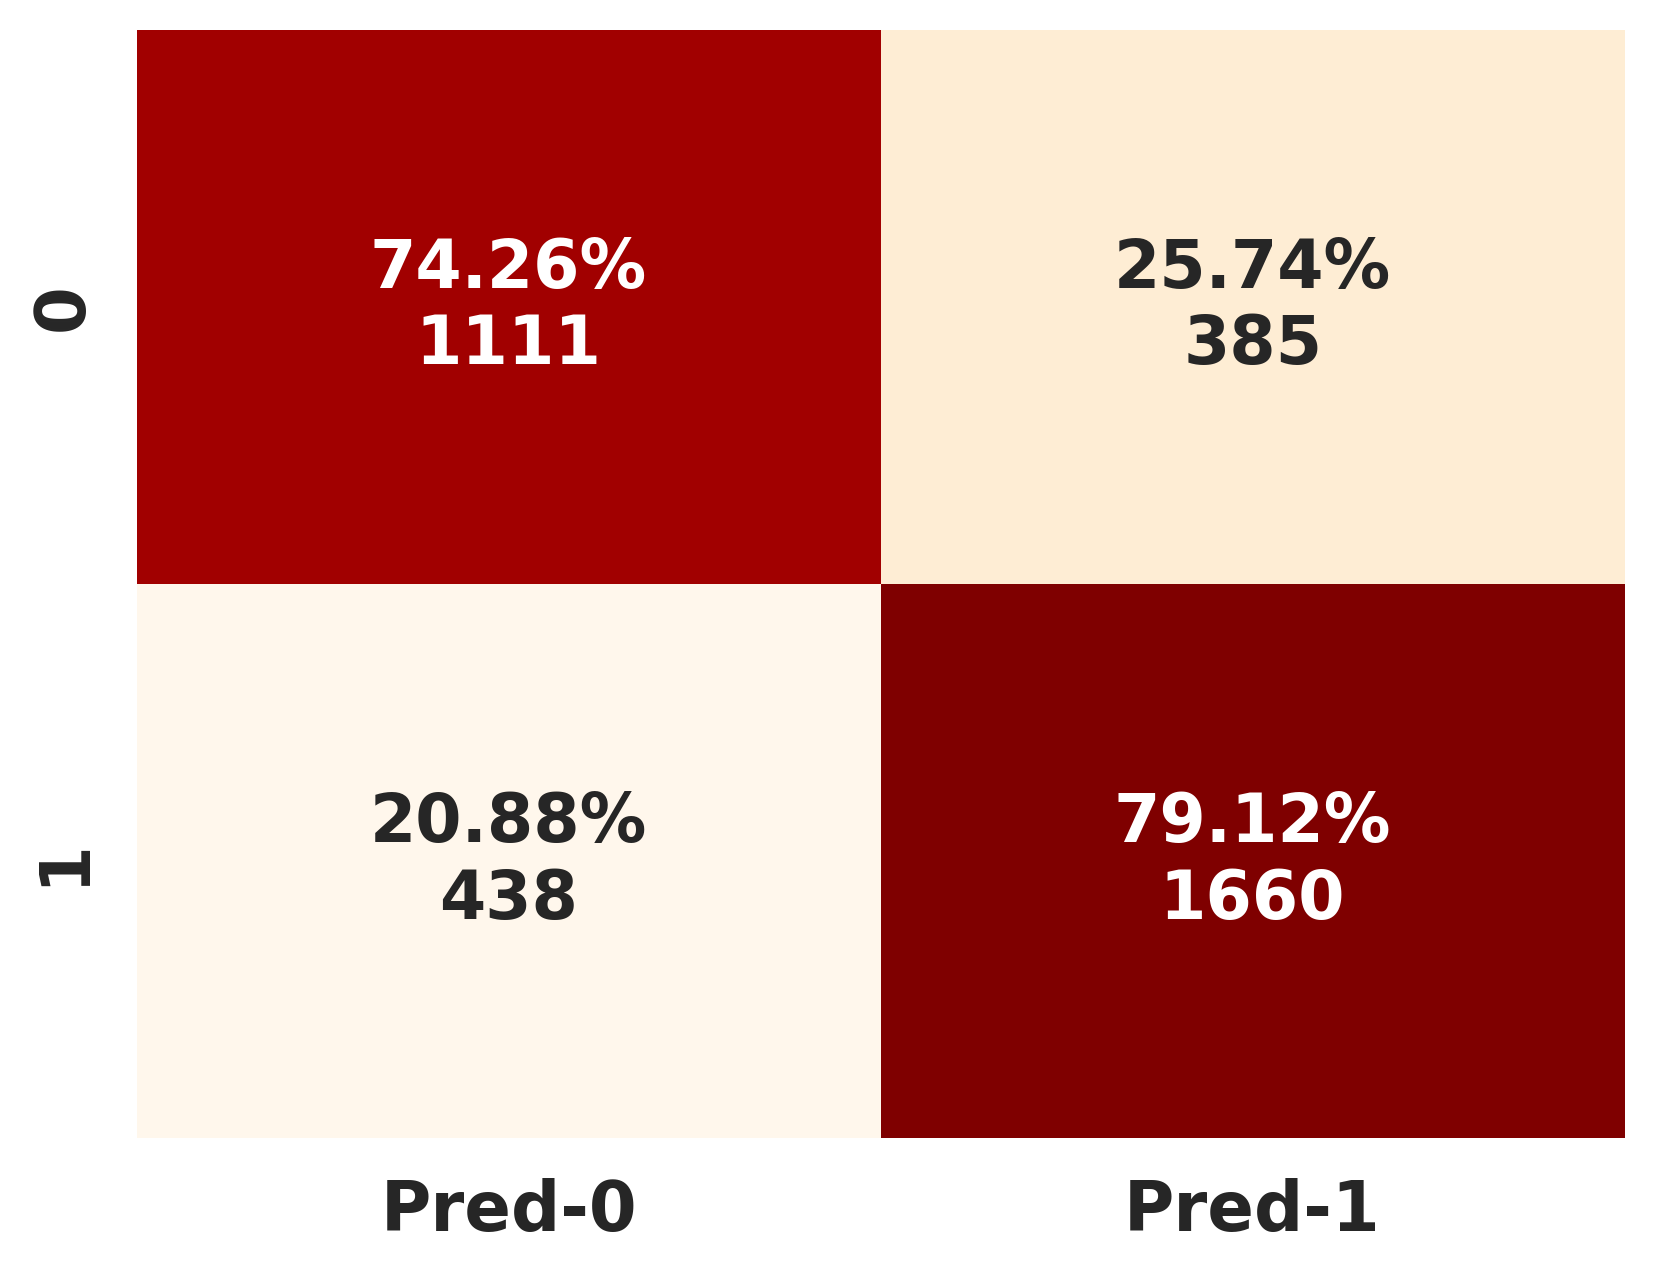

In [54]:

pred =  (nn.Sigmoid()(logits).cpu() > 0.5).float()
cm = metrics.confusion_matrix(stt.cpu(), pred)
cf_matrix = cm/np.repeat(np.expand_dims(np.sum(cm, axis=1), axis=-1), 2, axis=1)
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
# percentage based on true label 
gr = (cm/np.repeat(np.expand_dims(np.sum(cm, axis=1), axis=-1), 2, axis=1)).flatten()
group_percentages = ['{0:.2%}'.format(value) for value in gr]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_percentages, group_counts)]

labels = np.asarray(labels).reshape(2, 2)


xlabel = ['Pred-%d'%i for i in range(2)]
ylabel = ['%d'%i for i in range(2)]

sns.set(font_scale = 1.5)

hm = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap = 'OrRd', \
annot_kws={"fontsize": 16}, xticklabels=xlabel, yticklabels=ylabel, cbar=False)
# hm.set(title=title)
fig = plt.gcf()
plt.show()

tensor([[0.],
        [1.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]])

In [49]:
logits.shape

torch.Size([3594, 1])

In [48]:
stt.shape

torch.Size([3594])

In [33]:
import torch.nn as nn 
nn.Sigmoid()(logits)

tensor([[0.2560],
        [0.6335],
        [0.3921],
        ...,
        [0.0863],
        [0.1691],
        [0.5942]], device='cuda:0')

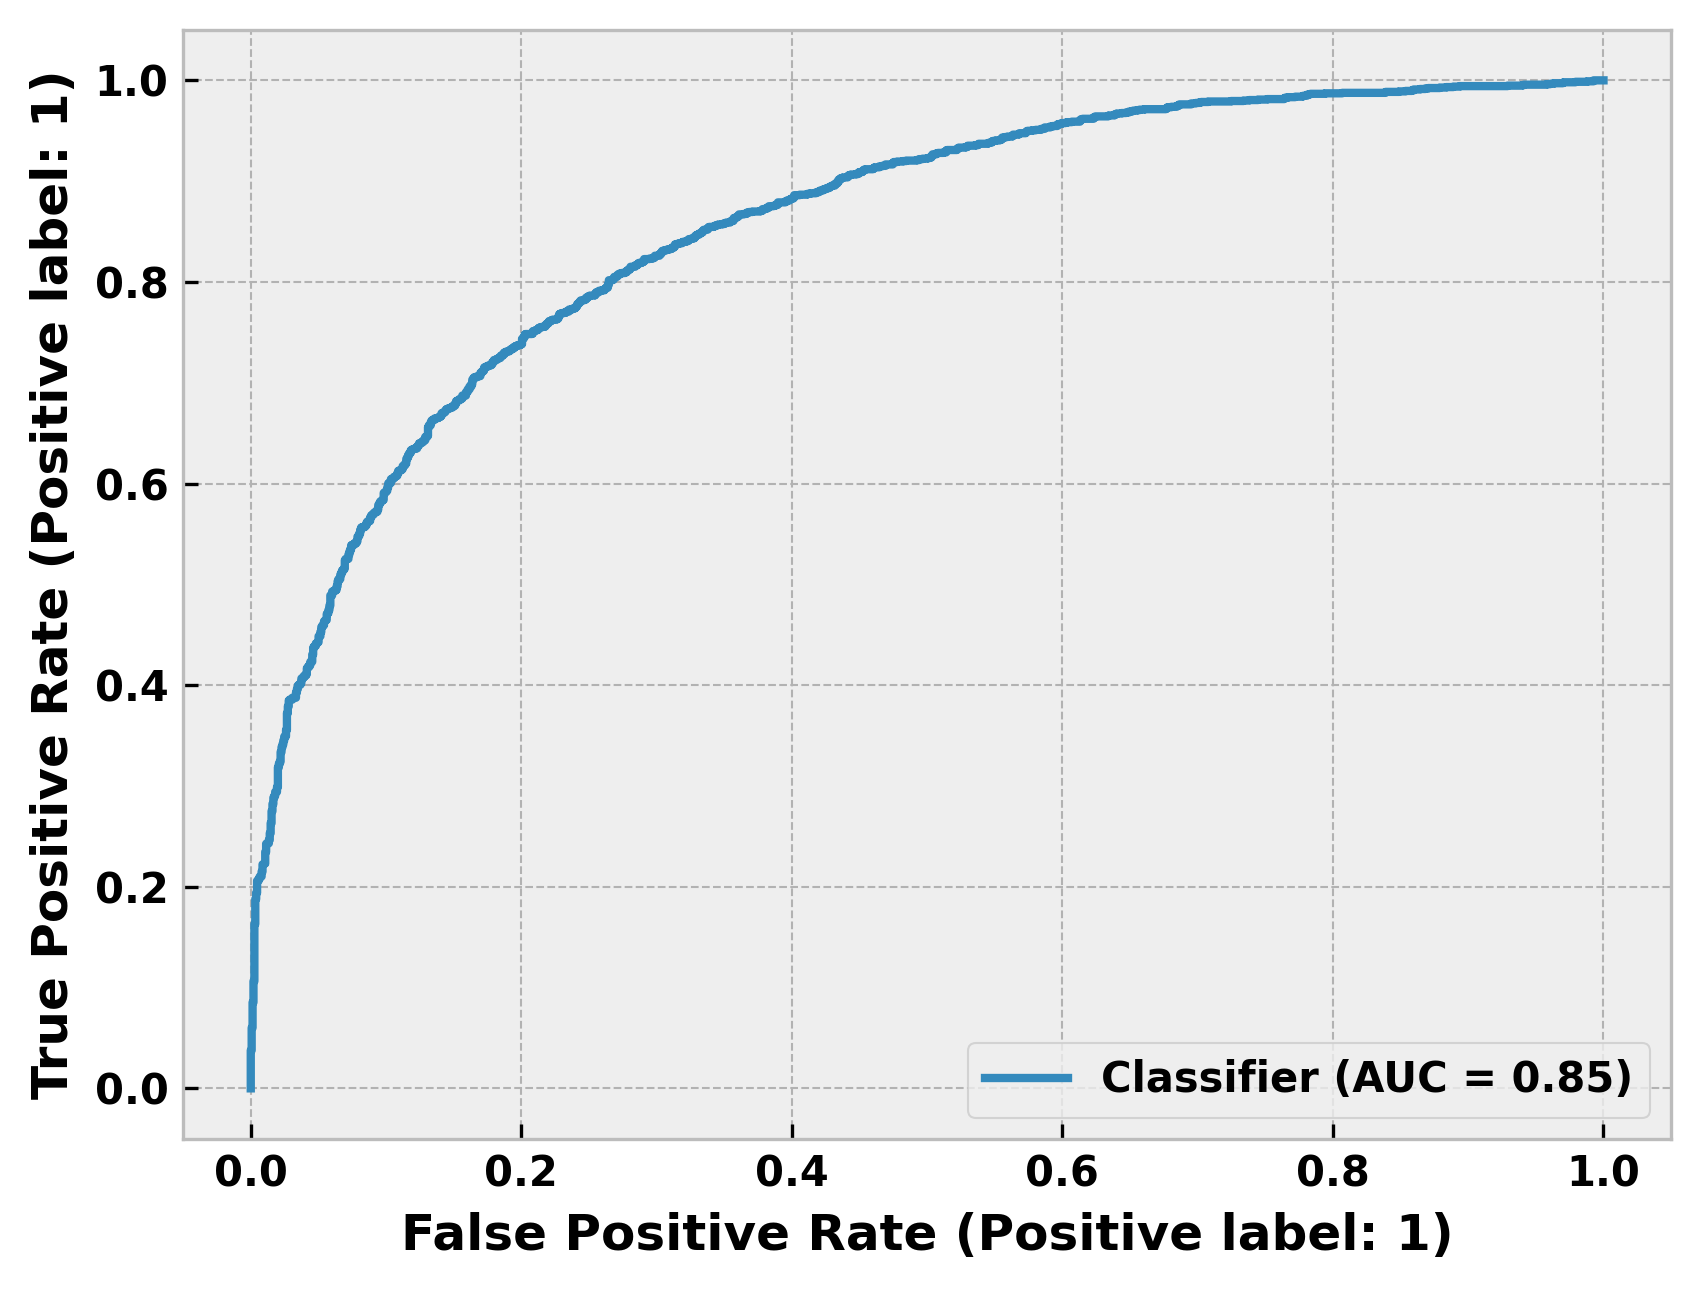

(array([335., 397., 325., 259., 234., 185., 229., 328., 439., 863.]),
 array([0.00387884, 0.10348403, 0.20308922, 0.30269441, 0.40229958,
        0.50190479, 0.60150999, 0.70111519, 0.80072033, 0.90032554,
        0.99993074]),
 <BarContainer object of 10 artists>)

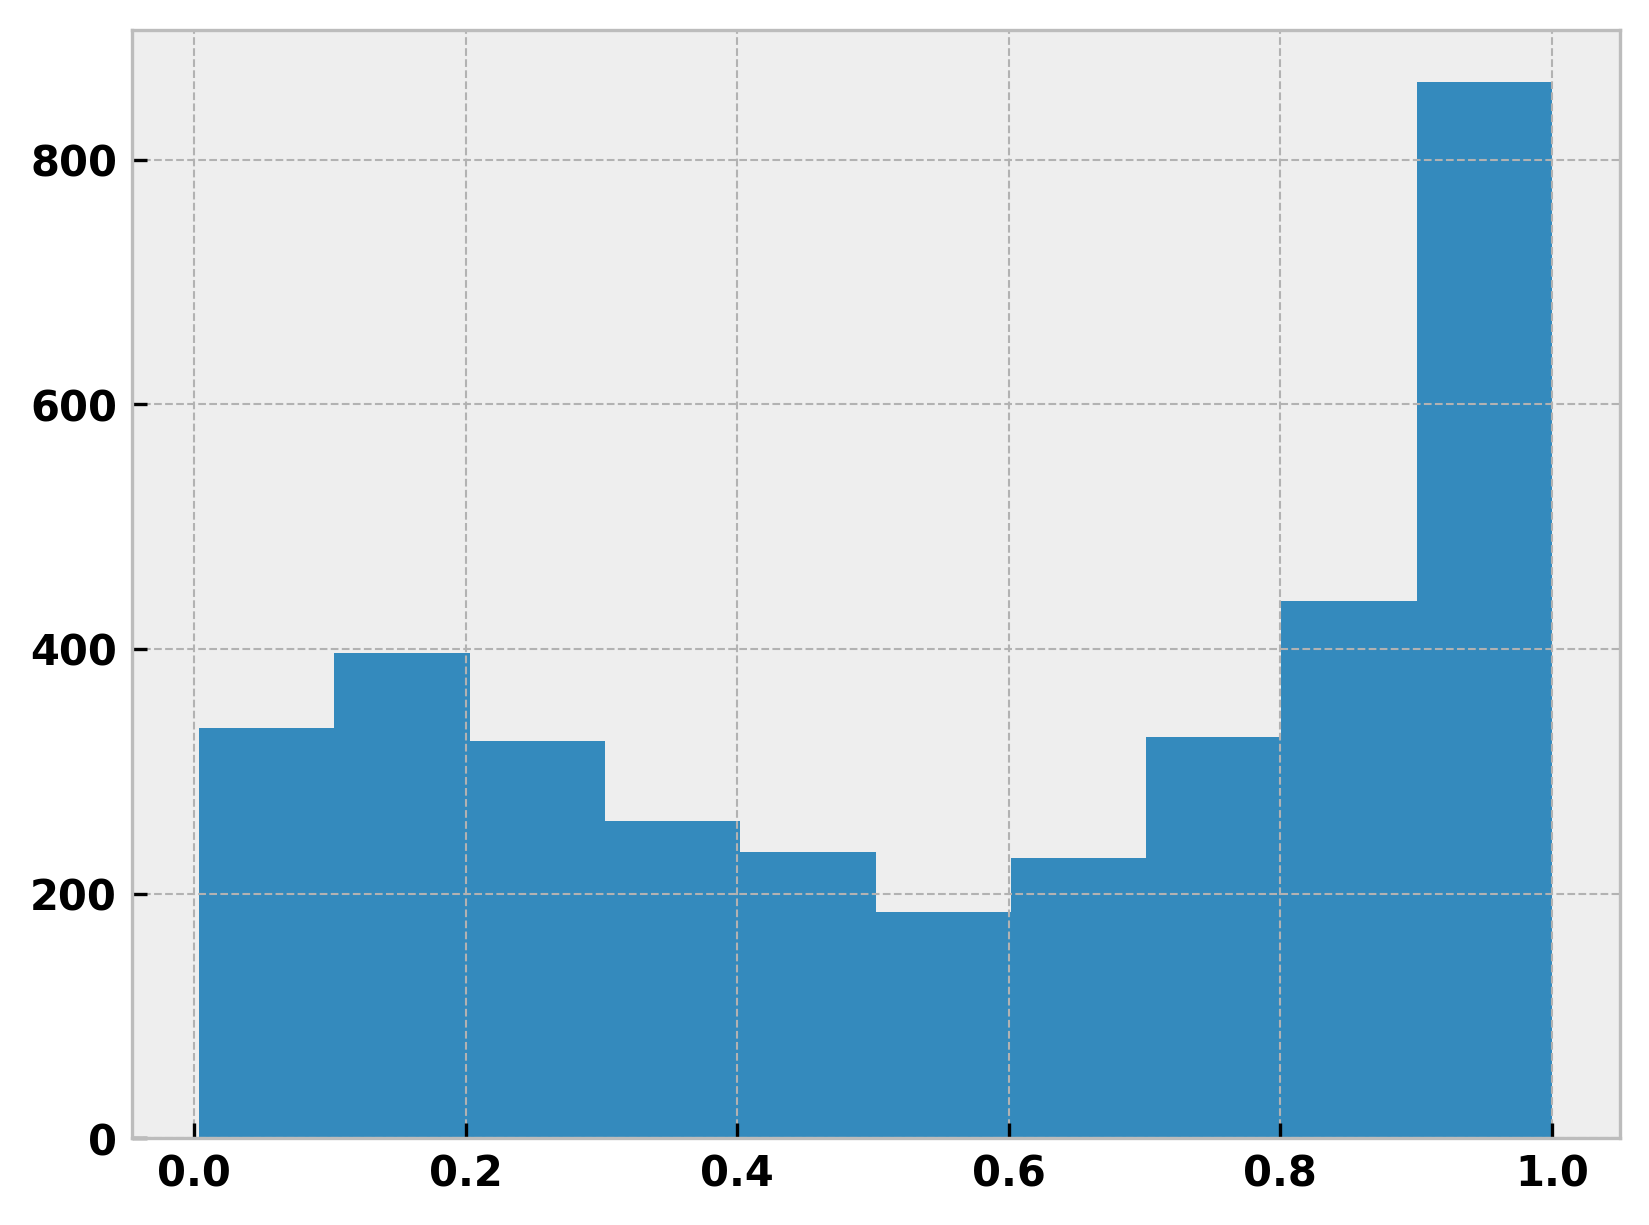

In [38]:
plt.hist(nn.Sigmoid()(logits).squeeze(-1).cpu())

In [18]:
enc = model.encoder


In [19]:
enc

TemporalConv(
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(200, 256, kernel_size=(3,), stride=(1,), padding=(2,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(2,))
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (dropout2): Dropout(p=0.2, inplace=False)
      (net): Sequential(
        (0): Conv1d(200, 256, kernel_size=(3,), stride=(1,), padding=(2,))
        (1): Chomp1d()
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(2,))
        (5): Chomp1d()
        (6): ReLU()
        (7): Dropout(p=0.2, inplace=False)
      )
      (downsample): Conv1d(200, 256, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
    )
    (1): TemporalBlock(
      (conv1): Conv1d(256, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
      (chomp1): Chomp1d()


In [23]:
b_logits

tensor([[-0.7592],
        [ 1.1073],
        [-1.2888],
        [ 1.3941]], device='cuda:0', grad_fn=<IndexBackward0>)

In [24]:
static

tensor([1., 1., 0., 1.], device='cuda:0')

In [ ]:
prediction = torch.argmax(b_logits, dim=-1)
# .unsqueeze(-1)
# label_t = torch.concat(label)
acc = (prediction == static).sum()/len(pred_t)

In [45]:
stt.shape

torch.Size([3594])